# Problem Statement
## In this problem statement, We are going to classify 10 classes of Leaf disease using Pytorch

# 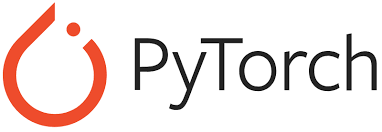

# Available frame works 

## 1) [Tensorflow](https://www.tensorflow.org/guide) 
## 2) [Pytorch](https://pytorch.org/docs/stable/index.html)
## 3) [Keras](https://keras.io/)
## 4) [Theano](http://deeplearning.net/software/theano/)

# What is Deep Learning?
## [Deep learning](https://en.wikipedia.org/wiki/Deep_learning) is a subset of machine learning where artificial neural networks, algorithms inspired by the human brain, learn from large amounts of data. ... Deep learning allows machines to solve complex problems even when using a data set that is very diverse, unstructured and inter-connected.



In [ ]:
from IPython.display import Image
Image("../input/neuralnetwork/Screenshot from 2020-06-21 16-18-13.png", width = '800px')

# What is Neural Network?
## [Artificial neural networks](https://en.wikipedia.org/wiki/Neural_network) or connectionist systems are computing systems vaguely inspired by the biological neural networks that constitute animal brains. Such systems "learn" to perform tasks by considering examples, generally without being programmed with task-specific rules. 


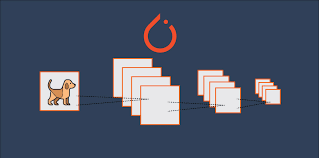

# Neural Network From Scratch

## The Input Layer, Hiden Layer, Output Layer can be customizable. 
## The Hidden layer can be a multilayer. When the layer is more then two Layer is called Deep Neural Network

# CNN Architecture 

![](https://pytorch.org/tutorials/_images/mnist.png)

# Required Library

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import numpy as np
from torch import nn
from PIL import Image
from torch import optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models

# Spliting the Dataset

In [ ]:
# we are loading the dataset
data_dir = '../input/leafdataset/test'


def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.485, 0.456, 0.406], # PyTorch recommends these but in this
                                       #                     [0.229, 0.224, 0.225]) # case I didn't get good results
                                       ])

    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

## Next we’ll determine whether we have GPU or not. I assume that if you’re doing this you have a GPU-powered machine, otherwise the code will be at least 10 times slower. But it’s a good idea to generalize and check for the GPU availability.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

## Now we’re getting into the interesting part of the deep neural network. First, we have to freeze the pre-trained layers, so we don’t backprop through them during training. Then, we re-define the final fully-connected the layer, the one that we’ll train with our images. We also create the criterion (the loss function) and pick an optimizer (Adam in this case) and learning rate.

In [ ]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# model.to(device)

## And now finally, let’s train our model! There’s just one epoch in this example but in most cases you’ll need more. The basic process is quite intuitive from the code: You load the batches of images and do the feed forward loop. Then calculate the loss function, and use the optimizer to apply gradient descent in back-propagation.

## It’s that simple with PyTorch. Most of the code below deals with displaying the losses and calculate accuracy every 10 batches, so you get an update while training is running. During validation, don’t forget to set the model to eval() mode, and then back to train() once you’re finished.

# Training the Model

In [ ]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:

        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:

                    inputs, labels = inputs.to(device),  labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =  top_class == labels.view(*top_class.shape)
                    accuracy +=   torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'leaf.pth')

## And… after you wait a few minutes (or more, depending on the size of your dataset and the number of epochs), training is done and the model is saved for later predictions!

## There is one more thing you can do now, which is to plot the training and validation losses:

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Testing the model

In [ ]:
data_dir = '../input/leafdataset/test'

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

## Checking, If the Cuda is Available or Not

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('leaf.pth')
# model.eval()

## The function that predicts the class of a specific image is very simple. Note that it requires a Pillow image, not a file path.

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

## Now for easier testing, I also created a function that will pick a number of random images from the dataset folders:

In [ ]:
def get_random_images(num):
    data_dir = '../input/leafdataset/test'
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

## Finally, to demo the prediction function, I get the random image sample, predict them and display the results:

In [ ]:
classes = ['Tomato__Target_Spot','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_mosaic_virus','Tomato__Tomato_YellowLeaf__Curl_Virus']
to_pil = transforms.ToPILImage()
images, labels = get_random_images(3)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()